<a href="https://colab.research.google.com/github/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/blob/main/Epileptic_Seizure_Prediction_using_EEG_bonn_data_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch.optim import Adam, SGD

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers


## Reading Data

In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
raw_data.shape

(11500, 180)

In [4]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [5]:
data = raw_data.values
data = data[0:11501, 1:180]
data.shape

(11500, 179)

In [6]:
type(data)

numpy.ndarray

## Classifying data categories

In [7]:
D = data
df_1 = D[D[:, 178] == 1]
df_2 = D[D[:, 178] == 2]
df_3 = D[D[:, 178] == 3]
df_4 = D[D[:, 178] == 4]
df_5 = D[D[:, 178] == 5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Experiment 1: Comparing CNN and BiLSTM on Epilepsy versus Healthy Data Categories

In [8]:
df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

In [9]:
D1.shape

(4600, 179)

### Creating training (80), validation(10) and test(10) data from category 1 and 3


In [10]:
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)

label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(3680,) (3680, 178, 1)
(460,) (460, 178, 1)
(460,) (460, 178, 1)


### Define model evaluation function

In [11]:
def evaluate_model(history, X_test, y_test, model):
  scores = model.evaluate((X_test), y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  print(history)
  fig1, ax_acc = plt.subplots()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model - Accuracy')
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show()

  fig2, ax_loss = plt.subplots()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model - Loss')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.show()
  target_names = ['1', '2', '3']

  y_true = []
  for element in y_test:
    y_true.append(np.argmax(element))

  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba, axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)

### Define CNN network

In [12]:
def network_CNN(X_train, y_train):
  im_shape = (X_train.shape[1], 1)
  inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')

  conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
  batch_normalization = BatchNormalization()(conv1d_1)
  max_pooling1d = layers.MaxPooling1D(2, padding='same')(batch_normalization)

  conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
  batch_normalization_1 = BatchNormalization()(conv1d_2)
  max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)

  flatten = Flatten()(max_pooling1d_1)

  dense = Dense(32)(flatten)
  dense_1 = Dense(16)(dense)

  main_output = Dense(2)(dense_1)

  model1 = Model(inputs = inputs_cnn, outputs=main_output)
  model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model1


In [13]:
## Define CNN model to be trained on epileptic vs healthy data
model1 = network_CNN(data_train, label_train)
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 32)           224       
                                                                 
 batch_normalization (BatchN  (None, 173, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 87, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 85, 64)           256   

In [14]:
from sqlalchemy.sql.expression import true
## Train CNN network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = 'checkpoint_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history = model1.fit(data_train, label_train, epochs=500, batch_size=32, validation_data=(data_val, label_val), callbacks=[model_checkpoint_callback])

Epoch 1/500
115/115 [==============================] - 14s 11ms/step - loss: 0.8468 - accuracy: 0.8160 - val_loss: 0.7127 - val_accuracy: 0.7587
Epoch 2/500
115/115 [==============================] - 1s 6ms/step - loss: 0.5918 - accuracy: 0.9011 - val_loss: 0.5560 - val_accuracy: 0.9196
Epoch 3/500
115/115 [==============================] - 1s 5ms/step - loss: 0.6298 - accuracy: 0.8905 - val_loss: 0.6148 - val_accuracy: 0.9174
Epoch 4/500
115/115 [==============================] - 1s 6ms/step - loss: 0.6506 - accuracy: 0.9035 - val_loss: 0.6464 - val_accuracy: 0.9391
Epoch 5/500
115/115 [==============================] - 1s 5ms/step - loss: 0.6679 - accuracy: 0.9155 - val_loss: 0.6675 - val_accuracy: 0.9435
Epoch 6/500
115/115 [==============================] - 1s 6ms/step - loss: 0.6694 - accuracy: 0.9130 - val_loss: 0.6705 - val_accuracy: 0.9457
Epoch 7/500
115/115 [==============================] - 1s 5ms/step - loss: 0.6705 - accuracy: 0.9128 - val_loss: 0.6705 - val_accuracy: 0.94

Accuracy: 80.65%


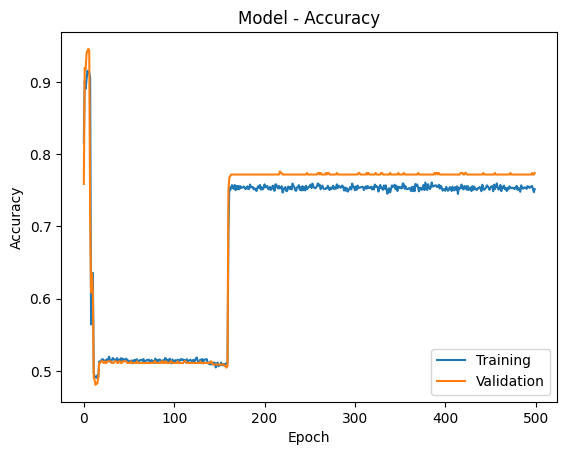

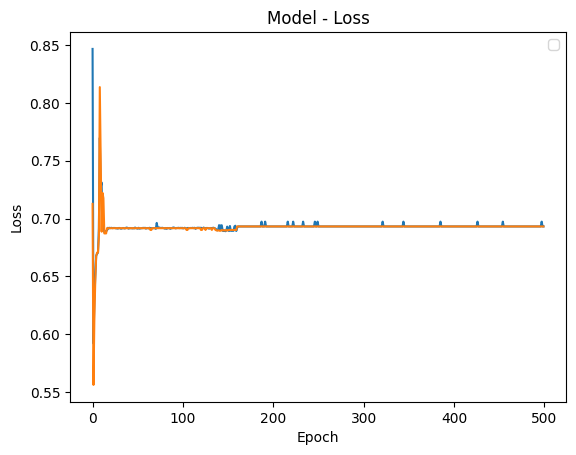

15/15 [==============================] - 0s 3ms/step


In [15]:
# print validation accuracy and plot accuracy and loss
evaluate_model(history, data_test, label_test, model1)
y_pred = model1.predict(data_test)

## Defining Bidirectional LSTM model

In [16]:
def network_LSTM(X_train, y_train):
  im_shape = (X_train.shape[1], 1)
  inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')

  dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
  lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
  dropout = Dropout(0.3)(lstm)
  batch_normalization = BatchNormalization(name='batch_normalization')(dropout)

  dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
  dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
  batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
  main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

  model = Model(inputs=inputs_lstm, outputs=main_output)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

  

In [17]:
model2 = network_LSTM(data_train, label_train)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [18]:
# Train BiLSTM on epileptic vs healthy data
save_path = 'checkpoint_2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weight_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

history2 = model2.fit(data_train, label_train, epochs=100, batch_size=32, validation_data=(data_val, label_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9117

115/115 [==============================] - 22s 139ms/step - loss: 0.2323 - accuracy: 0.9117 - val_loss: 0.1813 - val_accuracy: 0.9348
Epoch 2/100
114/115 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9430

115/115 [==============================] - 15s 131ms/step - loss: 0.1574 - accuracy: 0.9432 - val_loss: 0.0926 - val_accuracy: 0.9652
Epoch 3/100
115/115 [==============================] - 2s 16ms/step - loss: 0.1288 - accuracy: 0.9595 - val_loss: 0.1892 - val_accuracy: 0.9478
Epoch 4/100
115/115 [==============================] - 2s 15ms/step - loss: 0.1257 - accuracy: 0.9609 - val_loss: 0.1026 - val_accuracy: 0.9565
Epoch 5/100
113/115 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9569

115/115 [==============================] - 15s 132ms/step - loss: 0.1293 - accuracy: 0.9571 - val_loss: 0.0569 - val_accuracy: 0.9783
Epoch 6/100
115/115 [==============================] - 2s 16ms/step - loss: 0.1067 - accuracy: 0.9685 - val_loss: 0.0956 - val_accuracy: 0.9761
Epoch 7/100
115/115 [==============================] - 2s 15ms/step - loss: 0.1081 - accuracy: 0.9677 - val_loss: 0.0705 - val_accuracy: 0.9739
Epoch 8/100
115/115 [==============================] - 2s 20ms/step - loss: 0.1100 - accuracy: 0.9647 - val_loss: 0.0752 - val_accuracy: 0.9739
Epoch 9/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0974 - accuracy: 0.9671 - val_loss: 0.0764 - val_accuracy: 0.9696
Epoch 10/100
115/115 [==============================] - 2s 15ms/step - loss: 0.1061 - accuracy: 0.9666 - val_loss: 0.0716 - val_accuracy: 0.9761
Epoch 11/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0825 - accuracy: 0.9734 - val_loss: 0.1237 - val_accuracy: 0.9696


115/115 [==============================] - 14s 121ms/step - loss: 0.0775 - accuracy: 0.9750 - val_loss: 0.0550 - val_accuracy: 0.9804
Epoch 19/100
115/115 [==============================] - 2s 16ms/step - loss: 0.0944 - accuracy: 0.9666 - val_loss: 0.0643 - val_accuracy: 0.9717
Epoch 20/100
112/115 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9760

115/115 [==============================] - 15s 132ms/step - loss: 0.0793 - accuracy: 0.9758 - val_loss: 0.0576 - val_accuracy: 0.9848
Epoch 21/100
115/115 [==============================] - 2s 20ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.0994 - val_accuracy: 0.9739
Epoch 22/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0626 - accuracy: 0.9777 - val_loss: 0.0665 - val_accuracy: 0.9804
Epoch 23/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0602 - accuracy: 0.9793 - val_loss: 0.0667 - val_accuracy: 0.9761
Epoch 24/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0605 - accuracy: 0.9799 - val_loss: 0.0692 - val_accuracy: 0.9804
Epoch 25/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0465 - accuracy: 0.9842 - val_loss: 0.0633 - val_accuracy: 0.9804
Epoch 26/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0688 - accuracy: 0.9772 - val_loss: 0.0828 - val_accuracy: 0.9

115/115 [==============================] - 15s 127ms/step - loss: 0.0347 - accuracy: 0.9883 - val_loss: 0.0683 - val_accuracy: 0.9870
Epoch 40/100
115/115 [==============================] - 2s 18ms/step - loss: 0.0401 - accuracy: 0.9867 - val_loss: 0.0518 - val_accuracy: 0.9848
Epoch 41/100
115/115 [==============================] - 2s 18ms/step - loss: 0.0483 - accuracy: 0.9823 - val_loss: 0.0630 - val_accuracy: 0.9783
Epoch 42/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0414 - accuracy: 0.9867 - val_loss: 0.0697 - val_accuracy: 0.9870
Epoch 43/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0347 - accuracy: 0.9886 - val_loss: 0.0662 - val_accuracy: 0.9848
Epoch 44/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0757 - val_accuracy: 0.9870
Epoch 45/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0319 - accuracy: 0.9883 - val_loss: 0.0887 - val_accuracy: 0.9

115/115 [==============================] - 14s 119ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0614 - val_accuracy: 0.9891
Epoch 74/100
115/115 [==============================] - 2s 21ms/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0780 - val_accuracy: 0.9783
Epoch 75/100
115/115 [==============================] - 2s 16ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.1136 - val_accuracy: 0.9783
Epoch 76/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.1049 - val_accuracy: 0.9783
Epoch 77/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.0819 - val_accuracy: 0.9804
Epoch 78/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0390 - accuracy: 0.9875 - val_loss: 0.2061 - val_accuracy: 0.9283
Epoch 79/100
115/115 [==============================] - 2s 15ms/step - loss: 0.0295 - accuracy: 0.9910 - val_loss: 0.0874 - val_accuracy: 0.9

Accuracy: 97.83%


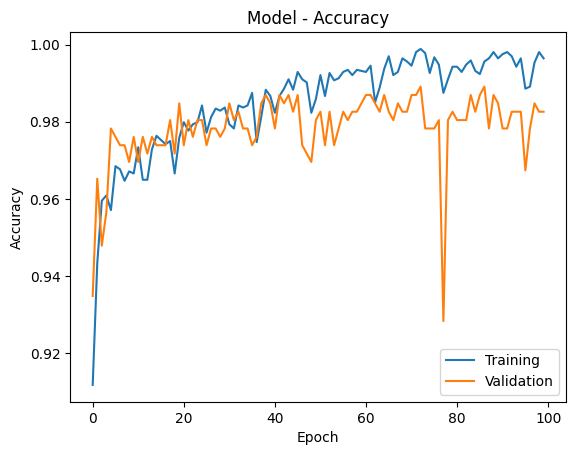

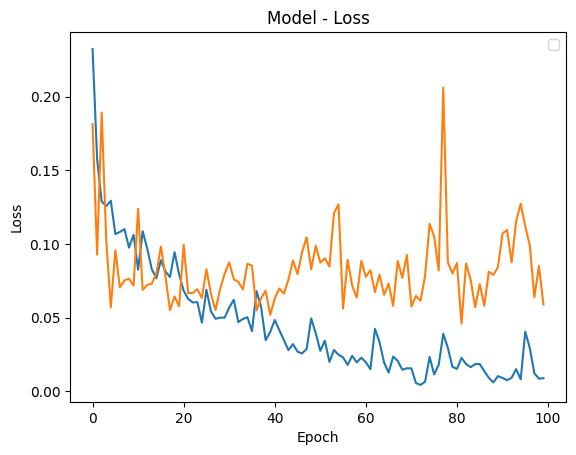

15/15 [==============================] - 1s 11ms/step


In [19]:
evaluate_model(history2, data_test, label_test, model2)

Accuracy: 98.26%


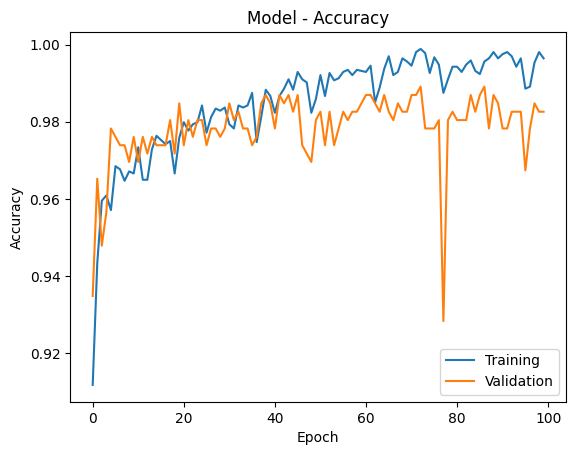

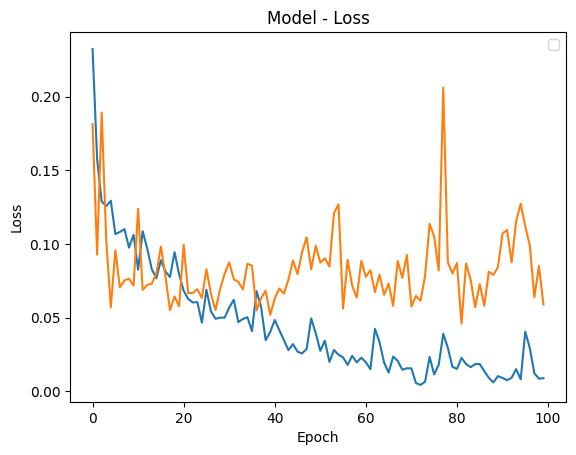

15/15 [==============================] - 0s 8ms/step


In [20]:
model2.load_weights(save_path)
evaluate_model(history2, data_test, label_test, model2)

## Experiment 2: Comparing CNN and BiLSTM on Epilepsy versus all other data categories

In [21]:
D = data
df_1 = D[D[:, 178] == 1]
df_2 = D[D[:, 178] == 2]
df_3 = D[D[:, 178] == 3]
df_4 = D[D[:, 178] == 4]
df_5 = D[D[:, 178] == 5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


In [22]:
# Concatenate 4 categories into 1 data set
df_2[:, 178] = df_2[:, 178] - 2
df_3[:, 178] = df_3[:, 178] - 3
df_4[:, 178] = df_4[:, 178] - 4
df_5[:, 178] = df_5[:, 178] - 5

D2 = np.concatenate([df_1, df_2, df_3, df_4, df_5])

In [23]:
number_of_rows = D2.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train_all = D2[random_indices, -1]
data_train_all = D2[random_indices, :-1]

D2_rest = np.delete(D2, random_indices, 0)

number_of_rows = D2_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val_all = D2_rest[random_indices, -1]
data_val_all = D2_rest[random_indices, :-1]

D2_rest_rest = np.delete(D2_rest, random_indices, 0)

label_test_all = D2_rest_rest[:, -1]
data_test_all = D2_rest_rest[:, :-1]

data_train_all = np.expand_dims(data_train_all, axis=2)
data_val_all = np.expand_dims(data_val_all, axis=2)
data_test_all = np.expand_dims(data_test_all, axis=2)

print(label_train_all.shape, data_train_all.shape)
print(label_val_all.shape, data_val_all.shape)
print(label_test_all.shape, data_test_all.shape)

(9200,) (9200, 178, 1)
(1150,) (1150, 178, 1)
(1150,) (1150, 178, 1)


In [24]:
# Define CNN model to be trained on epileptic vs all data
model3 = network_CNN(data_train_all, label_train_all)
print(model3.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 173, 32)           224       
                                                                 
 batch_normalization_2 (Batc  (None, 173, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 87, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_3 (Batc  (None, 85, 64)           256 

In [25]:
## Train CNN network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = 'checkpoint_3'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history3 = model3.fit(data_train_all, label_train_all, epochs=100, batch_size=32, 
                     validation_data=(data_val_all, label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 6s 8ms/step - loss: 0.8282 - accuracy: 0.7863 - val_loss: 0.7630 - val_accuracy: 0.8200
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.7072 - accuracy: 0.7826 - val_loss: 0.6913 - val_accuracy: 0.7748
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.7040 - accuracy: 0.8267 - val_loss: 0.6925 - val_accuracy: 0.8243
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6955 - accuracy: 0.8457 - val_loss: 0.6931 - val_accuracy: 0.8426
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6929 - accuracy: 0.8415 - val_loss: 0.6931 - val_accuracy: 0.8400
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.8438 - val_loss: 0.6931 - val_accuracy: 0.8409
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.6929 - accuracy: 0.8395 - val_loss: 0.6931 - val_accuracy: 0.841

Accuracy: 80.43%


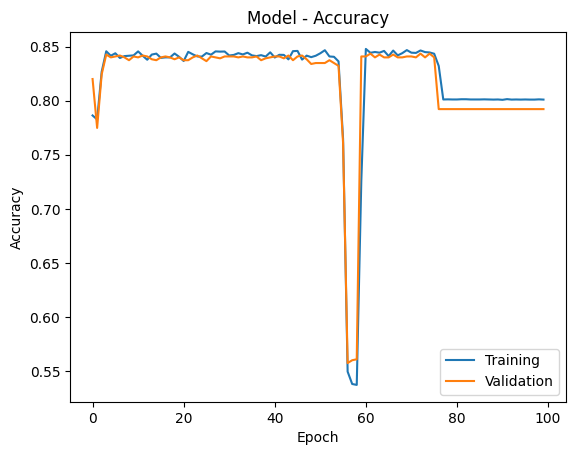

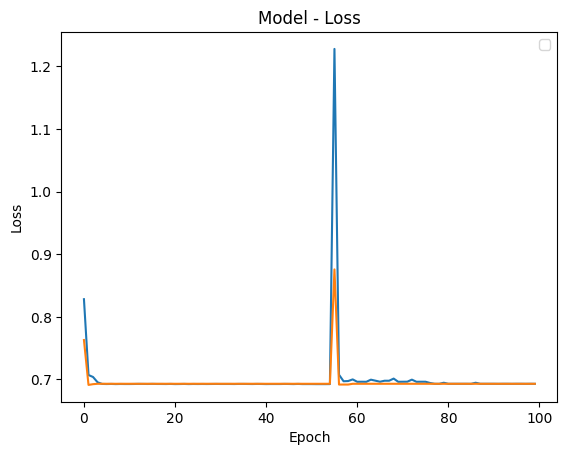

36/36 [==============================] - 0s 3ms/step


In [26]:
# print validation accuracy and plot accuracy and loss
evaluate_model(history3, data_test_all, label_test_all, model3)

Accuracy: 84.26%


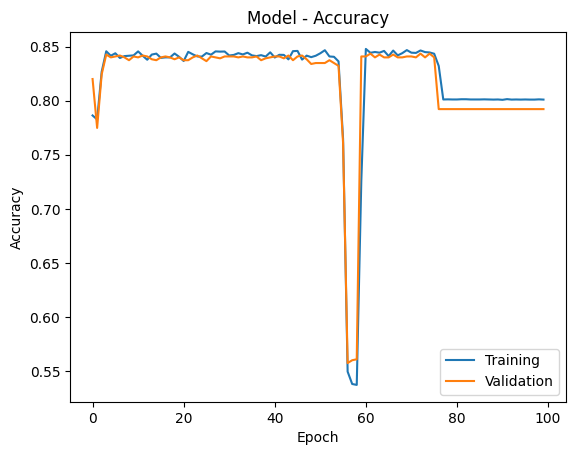

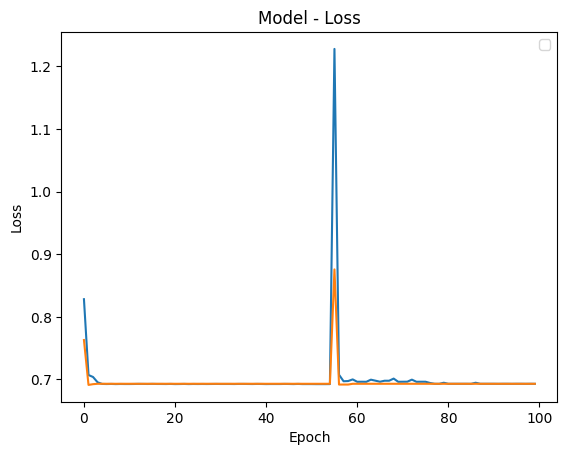

36/36 [==============================] - 0s 3ms/step


In [27]:
# print validation accuracy and plot accuracy and loss for the model's best version
model3.load_weights(save_path)
evaluate_model(history3, data_test_all, label_test_all, model3)

In [28]:
# Define BiLSTM model to be trained on epileptic vs all data
model4 = network_LSTM(data_train_all, label_train_all)
print(model4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [29]:
## Train CNN network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = 'checkpoint_4'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history4 = model4.fit(data_train_all, label_train_all, epochs=100, batch_size=32, 
                     validation_data=(data_val_all, label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 11s 21ms/step - loss: 0.2969 - accuracy: 0.8855 - val_loss: 0.1781 - val_accuracy: 0.9304
Epoch 2/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1855 - accuracy: 0.9374 - val_loss: 0.1328 - val_accuracy: 0.9461
Epoch 3/100
288/288 [==============================] - 5s 16ms/step - loss: 0.1563 - accuracy: 0.9453 - val_loss: 0.1830 - val_accuracy: 0.9348
Epoch 4/100
288/288 [==============================] - 5s 18ms/step - loss: 0.1466 - accuracy: 0.9474 - val_loss: 0.1262 - val_accuracy: 0.9478
Epoch 5/100
288/288 [==============================] - 5s 16ms/step - loss: 0.1258 - accuracy: 0.9542 - val_loss: 0.0736 - val_accuracy: 0.9704
Epoch 6/100
288/288 [==============================] - 5s 18ms/step - loss: 0.1229 - accuracy: 0.9571 - val_loss: 0.0730 - val_accuracy: 0.9748
Epoch 7/100
288/288 [==============================] - 4s 16ms/step - loss: 0.1078 - accuracy: 0.9618 - val_loss: 0.2877 - val_accuracy

Accuracy: 84.09%


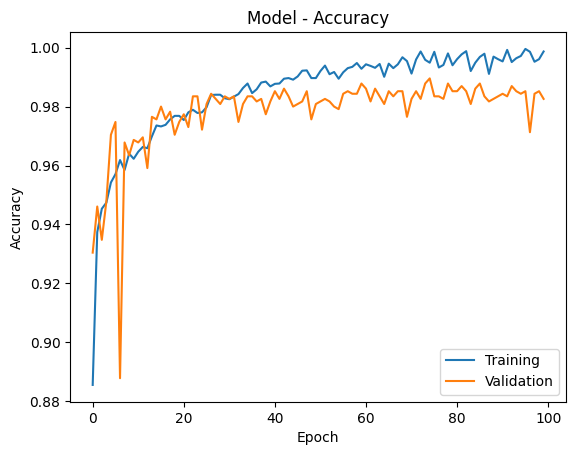

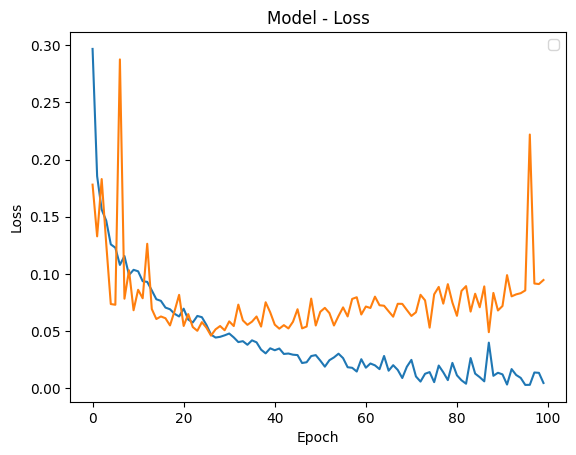

36/36 [==============================] - 0s 2ms/step


In [32]:
# print validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model4)

Accuracy: 84.09%


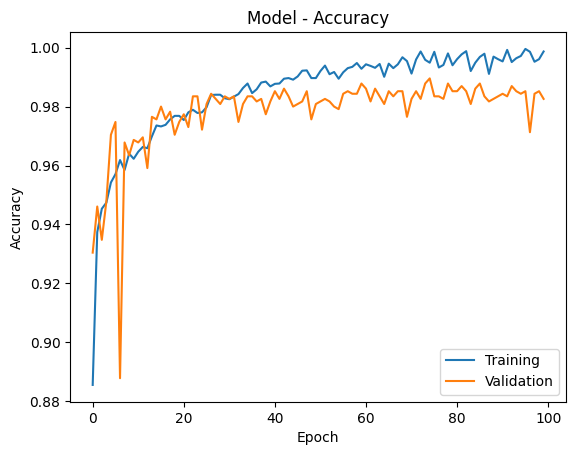

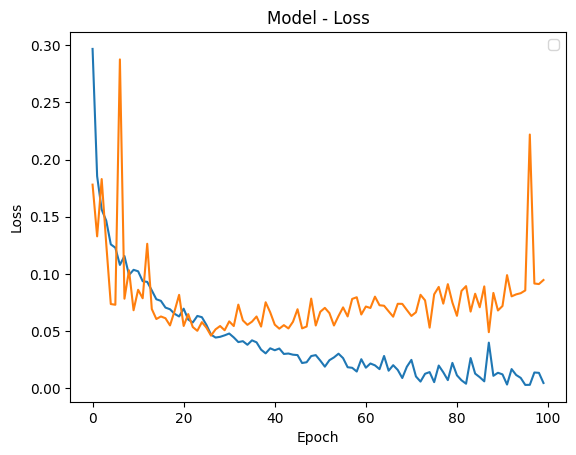

36/36 [==============================] - 0s 3ms/step


In [34]:
# print validation accuracy and plot accuracy and loss for the model's best version
model4.load_weights(save_path)
evaluate_model(history4, data_test_all, label_test_all, model4)

In [36]:
from keras.layers import Input, Dense
from keras.layers import Flatten, Dropout
from keras.layers import LayerNormalization, MultiHeadAttention, Dense
from keras.models import Model

def network_transformer(X_train, y_train):
  input_shape = (X_train.shape[1], 1)
  inputs = Input(shape=input_shape, name='input')

  transformer = MultiHeadAttention(num_heads=8, key_dim=16, dropout=0.1)
  normalization = LayerNormalization(epsilon=1e-6)
  dense_1 = Dense(32, activation='relu')
  dense_2 = Dense(16, activation='relu')
  dense_output = Dense(2, activation='softmax')

  x = normalization(inputs)
  x = transformer(x, x)
  x = Flatten()(x)
  x = dense_1(x)
  x = Dropout(0.2)(x)
  x = dense_2(x)
  outputs = dense_output(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [37]:
# Define Transformer model to be trained on epileptic vs all data
model5 = network_transformer(data_train_all, label_train_all)
print(model5.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 178, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 178, 1)      2           ['input[0][0]']                  
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 178, 1)      897         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                            

In [38]:
## Train transformer network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = 'checkpoint_5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history4 = model5.fit(data_train_all, label_train_all, epochs=100, batch_size=32, 
                     validation_data=(data_val_all, label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 9s 11ms/step - loss: 0.6266 - accuracy: 0.8005 - val_loss: 0.5790 - val_accuracy: 0.7922
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.5461 - accuracy: 0.8005 - val_loss: 0.5323 - val_accuracy: 0.7922
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.5143 - accuracy: 0.8005 - val_loss: 0.5161 - val_accuracy: 0.7922
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.5037 - accuracy: 0.8005 - val_loss: 0.5119 - val_accuracy: 0.7922
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.5006 - accuracy: 0.8005 - val_loss: 0.5111 - val_accuracy: 0.7922
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.4999 - accuracy: 0.8005 - val_loss: 0.5111 - val_accuracy: 0.7922
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.4997 - accuracy: 0.8005 - val_loss: 0.5112 - val_accuracy:

Accuracy: 80.35%


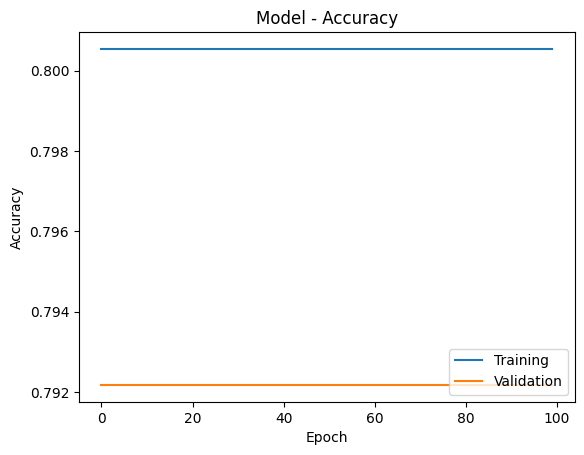

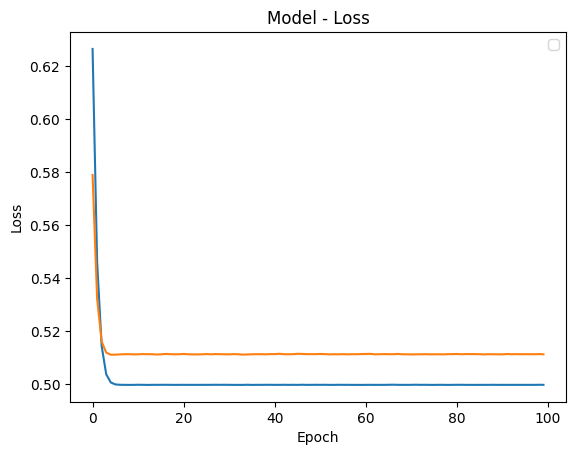

36/36 [==============================] - 0s 3ms/step


In [39]:
# print validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model5)